In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import importlib
import scalesc as ssc

/mnt/depts/dept04/compbio/projects/scaleSC/haotian/batch/github/scaleSC/scalesc/pp.py:226: SyntaxWarning: invalid escape sequence '\s'
  """
/edgehpc/dept/compbio/users/hzhang13/envs/scalesc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ScaleSC currently accepts a folder path as input. In this folder, there will be multiple .h5ad files each of which represents 
# a single sample with cells no more than max_cell_batch.
# There will be updates in the future to allow larger .h5ad files. (chunk it automatically if larger than max_cell_batch).

data_dir = '../../data_dir/1.7M_human_brain_ROSMAP/'

scalesc = ssc.ScaleSC(data_dir=data_dir, 
                  max_cell_batch=1e5, # no more than 1e5 is suggested
                  preload_on_cpu=True, 
                  preload_on_gpu=True, 
                  save_raw_counts=False,
                  save_norm_counts=False,
                  output_dir='test_scalesc_1.7M_results')

In [3]:
# calculate qc if qc hasn't been performed 
scalesc.calculate_qc_metrics()
print(scalesc.adata.shape)

(1681258, 32102)


In [4]:
# filer cells and genes
scalesc.filter_genes(min_count=3)
scalesc.filter_cells(min_count=200, max_count=6000)
print('shape after filtering', scalesc.adata.shape)

shape after filtering (1412491, 32102)


In [5]:
# hvg
scalesc.highly_variable_genes(n_top_genes=4000)
scalesc.adata.var[scalesc.adata.var['highly_variable'] == True]

,highly_variable
HES5,True
TTC34,True
AC242022.2,True
PRDM16-DT,True
PRDM16,True
...,...
TTTY9B,True
TTTY14,True
TTTY10,True
AC010086.3,True


In [6]:
# normal and log1p 
scalesc.normalize_log1p()

In [7]:
# pca use hvg
scalesc.pca(n_components=50, hvg_var='highly_variable')
print(scalesc.adata[sorted(scalesc.adata.obs_names)].obsm['X_pca'])

[[-9.05439933e+00  1.74787916e+01 -3.09010989e+00 ... -3.93096293e-02
  -5.92239577e-01 -5.79724847e-02]
 [ 7.79819068e+00 -1.43952020e+00  8.71067357e-01 ... -5.48653707e-01
  -4.36776068e-01  4.84731307e-01]
 [-1.09341786e+01  1.95978958e+01 -2.56666153e+00 ...  1.12767835e+00
  -9.02318970e-01  1.88064921e-01]
 ...
 [-1.28630820e+01 -1.04625826e+01 -4.80943228e+00 ... -1.48709269e+00
  -1.07830110e+00 -2.35686083e-01]
 [ 1.99850282e+01 -2.58058687e+00 -1.92519811e+00 ... -1.05671265e-03
  -5.82620802e-01 -5.26507829e-01]
 [-1.08248738e+01  1.90194263e+01 -2.57035860e+00 ...  1.30423164e+00
   3.76610475e-02 -1.68299565e+00]]


In [8]:
# harmony
scalesc.harmony(sample_col_name='sampleID', max_iter_harmony=10)

2025-02-26 18:55:03,760 - scaleSC - DEBUG - Harmony: Iteration 1 of 10
2025-02-26 18:55:28,724 - scaleSC - DEBUG - Harmony: Iteration 2 of 10
2025-02-26 18:55:51,232 - scaleSC - DEBUG - Harmony: Iteration 3 of 10
2025-02-26 18:56:14,672 - scaleSC - DEBUG - Harmony: Iteration 4 of 10
2025-02-26 18:56:32,320 - scaleSC - DEBUG - Harmony: Iteration 5 of 10
2025-02-26 18:56:43,382 - scaleSC - DEBUG - Harmony: Iteration 6 of 10
2025-02-26 18:56:55,579 - scaleSC - DEBUG - Harmony: Iteration 7 of 10
2025-02-26 18:57:06,286 - scaleSC - DEBUG - Harmony: Iteration 8 of 10
2025-02-26 18:57:17,001 - scaleSC - DEBUG - Harmony: Iteration 9 of 10
2025-02-26 18:57:41,276 - scaleSC - DEBUG - Harmony: Iteration 10 of 10
2025-02-26 18:57:52,517 - scaleSC - INFO - Harmony: Converged after 10 iterations


In [9]:
# neighbors & leiden & umap
scalesc.neighbors(n_neighbors=20, n_pcs=50, use_rep='X_pca_harmony')
scalesc.leiden(resolution=0.2, random_state=111)
scalesc.umap()

[2025-02-26 19:13:51.368] [RAFT] [info] optimizing graph
[2025-02-26 19:13:54.949] [RAFT] [info] Graph optimized, creating index


[2025-02-26 19:13:57.080] [CUML] [debug] n_neighbors=20
[2025-02-26 19:13:57.080] [CUML] [debug] Calling knn graph run
[2025-02-26 19:13:57.080] [CUML] [debug] Done. Calling fuzzy simplicial set
[2025-02-26 19:13:57.097] [CUML] [debug] Smooth kNN Distances
[2025-02-26 19:13:57.097] [CUML] [debug] Compute Membership Strength
[2025-02-26 19:14:07.039] [CUML] [debug] Done. Calling remove zeros
[2025-02-26 19:14:23.171] [CUML] [debug] Calling UMAP::init_and_refine() with precomputed KNN


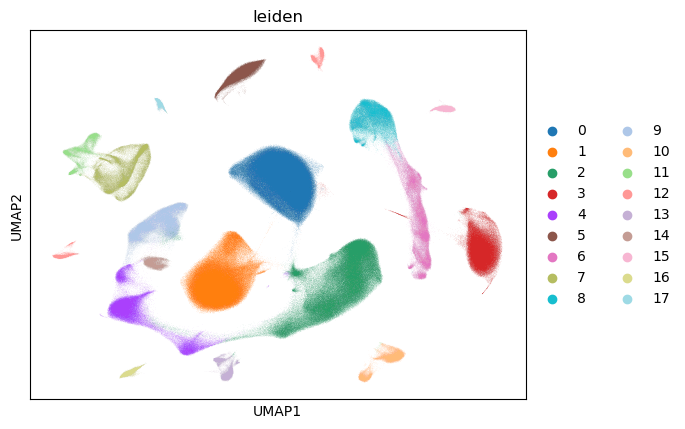

In [11]:
# plot umap
sc.pl.umap(scalesc.adata, color='leiden')

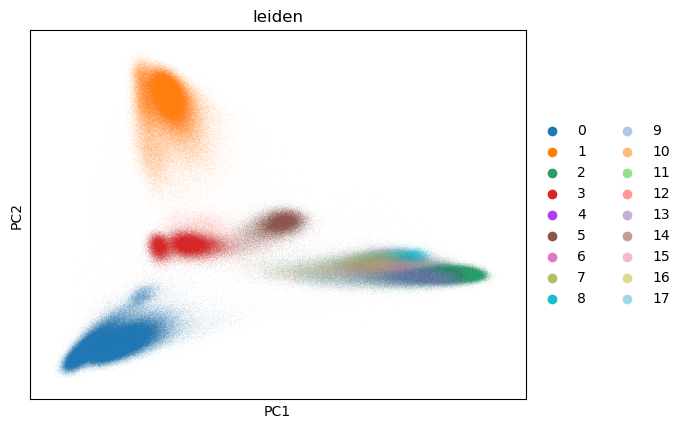

In [12]:
# plot pca
sc.pl.pca(scalesc.adata, color='leiden')

In [13]:
# save adata to disk, note: this adata doesn't contain count matrix 
scalesc.save()

In [14]:
# save normalized count matrix to disk in batches
scalesc.savex(name='norm_counts')

In [19]:
# get merged adata with count matrix, but have to perform it on CPU
scalesc.to_CPU()
adata = scalesc.adata_X
adata.obs['leiden'] = scalesc.adata.obs['leiden']
adata.obsm['X_umap'] = scalesc.adata.obsm['X_umap']
adata.var = scalesc.adata.var
adata = adata[:, adata.var['highly_variable']] # use highly variable genes only to speed up marker identification

In [22]:
# find markers and merge clusters
cluster_col_after_merge = ssc.adata_cluster_merge(adata, 'leiden')

2025-02-26 19:22:08,945 - scaleSC - DEBUG - Preparing data...
2025-02-26 19:22:37,575 - scaleSC - DEBUG - n_total_clusters: 18
2025-02-26 19:22:37,576 - scaleSC - DEBUG - 28.629664182662964 seconds
2025-02-26 19:22:37,576 - scaleSC - DEBUG - Calculating medians...
2025-02-26 19:22:47,801 - scaleSC - DEBUG - Time - calculate_median_sparse_fast_gpu: 10.224081039428711s
2025-02-26 19:22:47,801 - scaleSC - DEBUG - 10.224734544754028 seconds
2025-02-26 19:22:47,802 - scaleSC - DEBUG - Number of clusters to evaluate: 18
2025-02-26 19:22:49,464 - scaleSC - DEBUG - 1 out of 18:
2025-02-26 19:22:49,464 - scaleSC - DEBUG - 	0
2025-02-26 19:22:59,102 - scaleSC - DEBUG - Time - myXGBClassifier: 9.637359619140625s
2025-02-26 19:23:01,128 - scaleSC - DEBUG - Time - myDecisionTreeEvaluation: 2.0192928314208984s
2025-02-26 19:23:01,129 - scaleSC - DEBUG - 	['ST18', 'PLP1', 'RNF220', 'CNP', 'HHIP', 'SLC7A14-AS1', 'TMEM144', 'AL359091.1', 'ENPP2', 'MOBP', 'SLCO1A2', 'CNTN2', 'TF', 'CNDP1', 'ABCA8', 'PCS

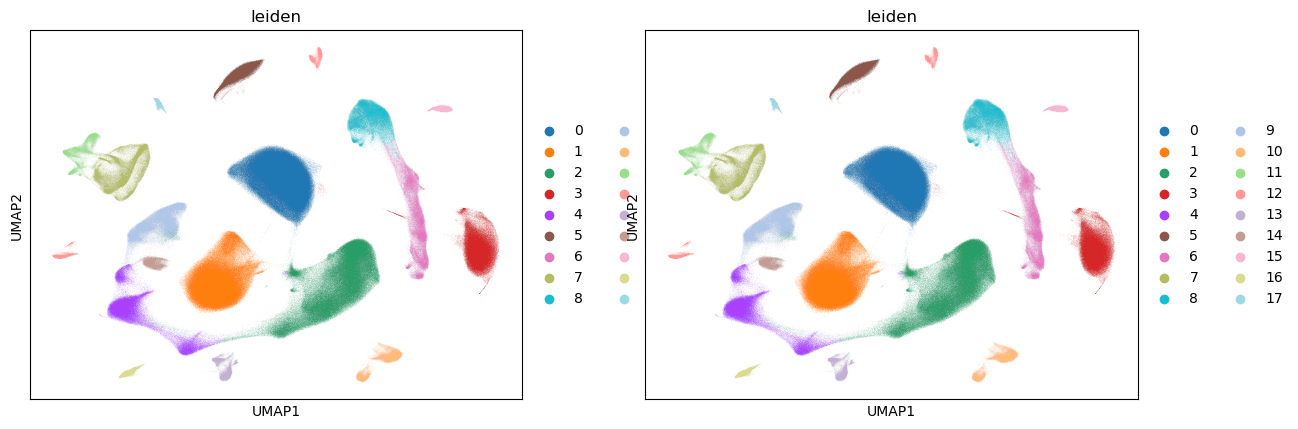

In [24]:
# actually there is no need to cluster in the default setting.
sc.pl.umap(adata, color=['leiden', cluster_col_after_merge])

In [25]:
# if you are looking for fewer clusters, one can specify the `threshold` parameter,
# higher threshold will result in fewer clusters. the value is between 0 and 1.
# now we can set up a 0.5 threshold to see how it works.

cluster_col_after_merge = ssc.adata_cluster_merge(adata, 'leiden', threshold=0.5)

2025-02-26 19:32:35,684 - scaleSC - DEBUG - Preparing data...
2025-02-26 19:32:35,696 - scaleSC - DEBUG - n_total_clusters: 18
2025-02-26 19:32:35,697 - scaleSC - DEBUG - 0.012273073196411133 seconds
2025-02-26 19:32:35,697 - scaleSC - DEBUG - Calculating medians...
2025-02-26 19:32:43,887 - scaleSC - DEBUG - Time - calculate_median_sparse_fast_gpu: 8.188768863677979s
2025-02-26 19:32:43,888 - scaleSC - DEBUG - 8.189664602279663 seconds
2025-02-26 19:32:43,888 - scaleSC - DEBUG - Number of clusters to evaluate: 18
2025-02-26 19:32:45,556 - scaleSC - DEBUG - 1 out of 18:
2025-02-26 19:32:45,556 - scaleSC - DEBUG - 	0
2025-02-26 19:32:55,791 - scaleSC - DEBUG - Time - myXGBClassifier: 10.234412431716919s
2025-02-26 19:32:57,830 - scaleSC - DEBUG - Time - myDecisionTreeEvaluation: 2.031750440597534s
2025-02-26 19:32:57,831 - scaleSC - DEBUG - 	['ST18', 'PLP1', 'RNF220', 'CNP', 'HHIP', 'SLC7A14-AS1', 'TMEM144', 'AL359091.1', 'ENPP2', 'MOBP', 'SLCO1A2', 'CNTN2', 'TF', 'CNDP1', 'ABCA8', 'PCS

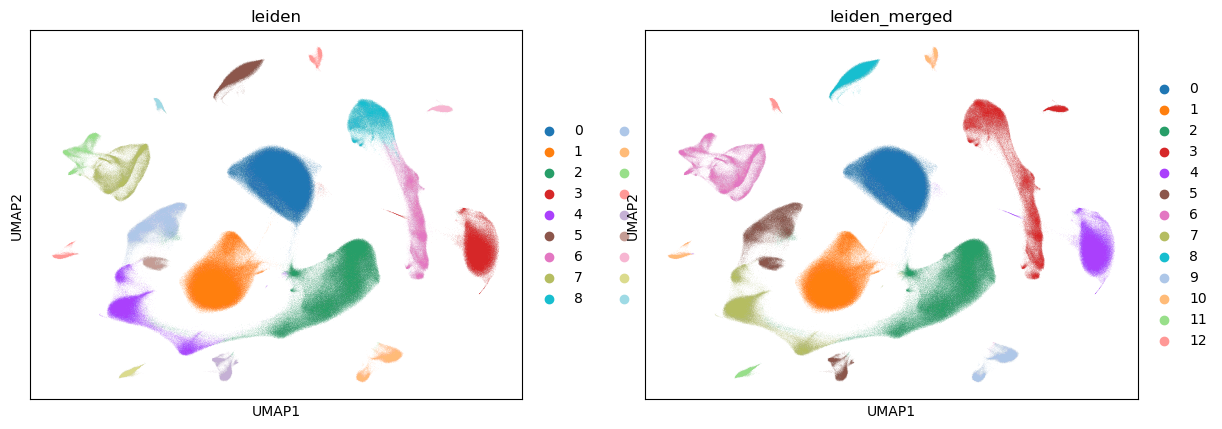

In [27]:
# now we can further reduce clusters from 18 to 12.
sc.pl.umap(adata, color=['leiden', cluster_col_after_merge])

In [18]:
# use another dataset to test
fname = '/edgehpc/dept/compbio/projects/scaleSC/data/marker_merge/TB_harmony.h5ad'
adata_TB = sc.read_h5ad(fname)
cluster_col_after_merge_TB = ssc.adata_cluster_merge(adata_TB, 'TB.leiden_res.1')

2024-11-04 09:34:58,308 - scaleSC - DEBUG - Preparing data...
2024-11-04 09:34:58,309 - scaleSC - DEBUG - n_total_clusters: 15
2024-11-04 09:34:58,310 - scaleSC - DEBUG - 0.0012178421020507812 seconds
2024-11-04 09:34:58,310 - scaleSC - DEBUG - Calculating medians...
2024-11-04 09:35:00,756 - scaleSC - DEBUG - Time - calculate_median_sparse_fast_gpu: 2.445831537246704s
2024-11-04 09:35:00,757 - scaleSC - DEBUG - 2.4464609622955322 seconds
2024-11-04 09:35:00,757 - scaleSC - DEBUG - Number of clusters to evaluate: 15
2024-11-04 09:35:00,954 - scaleSC - DEBUG - 1 out of 15:
2024-11-04 09:35:00,955 - scaleSC - DEBUG - 	0
2024-11-04 09:35:04,067 - scaleSC - DEBUG - Time - myXGBClassifier: 3.112135887145996s
2024-11-04 09:35:04,431 - scaleSC - DEBUG - Time - myDecisionTreeEvaluation: 0.3515009880065918s
2024-11-04 09:35:04,431 - scaleSC - DEBUG - 	['ATP10A', 'ARHGEF12', 'UBL3', 'GPR155', 'CD8B', 'ITGA1', 'CD8A', 'NFIA', 'CD226', 'RASGRF2', 'GALNT10', 'MYBL1', 'RUNX2', 'PRKCA', 'IL7R', 'MNAT

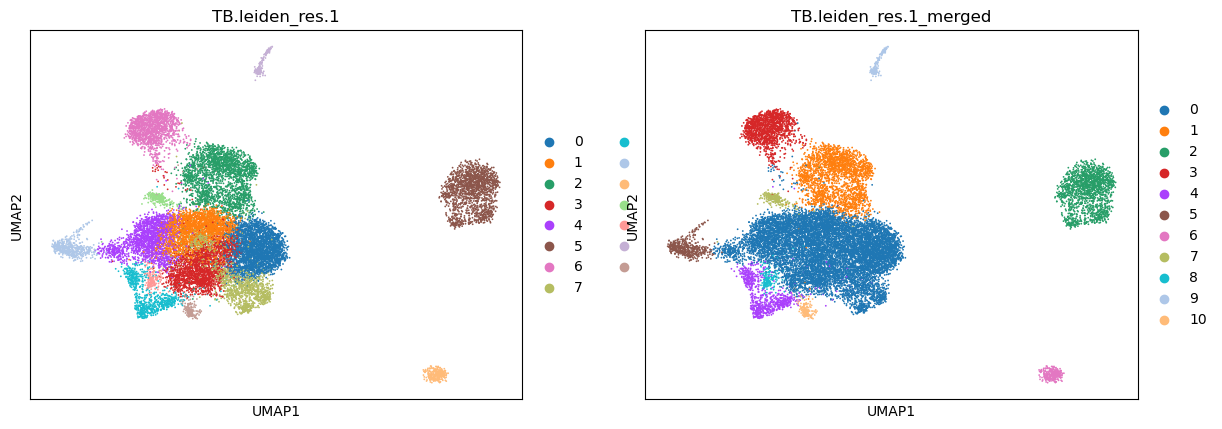

In [19]:
sc.pl.umap(adata_TB, color=['TB.leiden_res.1', cluster_col_after_merge_TB])